**Authors:** Jozef Hanč, Martina Hančová  <br> *[Faculty of Science](https://www.upjs.sk/en/faculty-of-science/?prefferedLang=EN), P. J. Šafárik University in Košice, Slovakia* <br> emails: [martina.hancova@upjs.sk](mailto:martina.hancova@upjs.sk)
***

# <font color = brown, size=6> Numerical inversion for $\mathcal{GDD}$ pdf calculations</font>

<font size=4> Python-based computational tools: </font>  **<font size=4>Python, NumPy, Cython, Numba</font>**  

# Trapezoidal rule vs. DE quadrature</font>

Trapezoidal (complex functions - Python), DE (complex, real functions - Python, Cython, Numba) 

In [1]:
N = 4 #test up to 10^N values of pdf

import numpy as np
import pandas as pd
from numpy import array as v
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from time import time
import math, cmath
import scipy

# accuracy in Python
def abs_errs(df1, df2):
    N = len(df1)
    errors = [abs(df1[i]-df2[i]) for i in range(N)]
    return errors

## $\mathcal{GDD}$ pdf  $-$ analytic expression

$
f(z)=
\dfrac{\beta_{1}^{\alpha_{1}} \beta_{2}^{\alpha_{2}}}{\beta^{\alpha-1}}
\begin{cases}
{\dfrac{e^{z \beta_{2}}}{\Gamma\left(\alpha_{2}\right)} U\left(1-\alpha_{2}, 2-\alpha,-z \beta\right),} & {z<0} \\[12pt]
\begin{array}{cc} 
\frac{\Gamma(\alpha-1)}{\beta^{a / 2-1} \Gamma\left(\alpha_{1}\right) \Gamma\left(\alpha_{2}\right)}, & \scriptstyle 1<\alpha \\ 
\infty,  & \scriptstyle 0<\alpha \leq 1 
\end{array}, & z=0 \\[12pt] 
{\dfrac{e^{-z \beta_{1}}}{\Gamma\left(\alpha_{1}\right)} U\left(1-\alpha_{1}, 2-\alpha, z \beta\right),} & {z>0}
\end{cases}
$


$\alpha=\alpha_{1}+\alpha_{2}, \quad \beta=\beta_{1}+\beta_{2}$

In [2]:
# pre-calulated analytic results from mpmath, Pari GP and Arb
dpari = {str(10**(n+1)):np.loadtxt('data/Pari_Sage_pdf'+str(10**(n+1))+'.txt', delimiter=',',
                                   dtype=np.longdouble) for n in range(N)}
dx = {str(10**(n+1)):np.loadtxt('data/xvalues'+str(10**(n+1))+'.txt', dtype=np.longdouble) for n in range(N)}

# Pdf as a numerical inversion integral
<div style="display:none">
$
 \newcommand{\a}{\alpha}
 \newcommand{\b}{\beta}
 \newcommand{\cft}{\varphi(t)}
  \newcommand{\Rv}[1]{\mathscr{R}^{#1}}
$
</div>


$$\large f(x)=  \frac{1}{\pi} 
\int_0^\infty \Re \left[e^{-itx}\cft\right]dt 
$$
$$ \normalsize
\cft=  \left(1-\dfrac{it}{\b_1}\right)^{-\a_1}\left(1+\dfrac{it}{\b_2}\right)^{-\a_2}, t\in \Rv{}
$$

**<font size=5> alternative form</font>**
$$
\large f(x)= \int_{0}^{\infty} g(x,t) dt 
$$

$$ 
\normalsize 
g(x,t) = r(t)\cos(xt-\phi(t)), 
$$

$$\normalsize r(t)= \frac{\b_1^{\a_1} \b_2^{\a_2}}{\pi\left(\b_1^2+t^2\right)^{\a_1/2}
\left(\b_2^2+t^2\right)^{\a_2 / 2}}, \quad \phi(t) = \a_1 \arctan \frac{t}{\b_1}-\a_2 \arctan \frac{t}{\b_2}$$

# DE, TR

In [3]:
# Ooura DE quadrature implementation in Python, Numba; folder TRandDE
from TRandDE.DEQuadratureNumba import *
from TRandDE.DEQuadrature import *
scipy.__version__, np.__version__

C:\Users\jozef\.conda\envs\py38\lib\site-packages\numba\core\cpu.py:78: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  numba.core.entrypoints.init_all()


('1.6.0', '1.19.2')

## Integrands and parameters

In [4]:
# setting parameters and integrands
eps, epss, epsss = 1e-3, 1e-10, 1e-15
omg = 1

a1, b1, a2, b2 = 0.5, 1.0, 8.5, 93.0
d = b1**a1*b2**a2/math.pi

In [5]:
# integrand Python, complex char function
def gcpy(t, x):
    phit = (1-1j*t/b1)**(-a1)*(1+1j*t/b2)**(-a2)
    return (1/math.pi*cmath.exp(-1j*t*x)*phit).real

In [6]:
# integrand Numba, complex and real char function
@njit(fastmath=True)
def gcn(t, x):
    phit = (1-1j*t/b1)**(-a1)*(1+1j*t/b2)**(-a2)
    return (1/math.pi*cmath.exp(-1j*t*x)*phit).real

@njit(fastmath=True)
def gn(t,x):
    phi = a1*math.atan(t/b1) - a2*math.atan(t/b2)
    r = 1/((b1*b1 + t*t)**(a1/2)*(b2*b2 + t*t)**(a2/2))
    return d*r*math.cos(x*t-phi)

In [7]:
%load_ext Cython

In [8]:
%%cython
cimport scipy.special.cython_special as cs
cimport libc.math as lc

def Gcy(double t, double x, double a1, double b1, double a2, double b2):
    cdef:
        double phi, r, d
    
    phi = a1*lc.atan(t/b1)-a2*lc.atan(t/b2)
    r = 1/(lc.pow(b1*b1 + t*t,a1/2)*lc.pow(b2*b2 + t*t,a2/2))
    d = lc.pow(b1,a1)*lc.pow(b2,a2)/lc.pi
    return d*r*lc.cos(x*t-phi)

In [9]:
# integrad Cython
def gcy(t,x):
    return Gcy(t,x, a1,b1,a2,b2)

## Comparing integrands

In [10]:
t,x = 0.32, 0.8

In [11]:
# cross-check values
gint = [gcpy, gcn, gn, gcy]
[gcpy(t,x), gcn(t,x), gn(t,x), gcy(t,x)]

[0.30799296627851114,
 0.3079929662785111,
 0.3079929662785113,
 0.30799296627851125]

In [12]:
# speed of integrands
runtimes = []
for fun in gint:
    print(fun.__name__, '('+str(t)+','+str(x)+') =', fun(t, x))
    %timeit -r 3 -n 10 fun(t, x)
    rt = %timeit -r 1 -oq fun(t, x)
    runtimes += [rt.average] 
    print('')

gcpy (0.32,0.8) = 0.30799296627851114
1.34 µs ± 210 ns per loop (mean ± std. dev. of 3 runs, 10 loops each)

gcn (0.32,0.8) = 0.3079929662785111
437 ns ± 101 ns per loop (mean ± std. dev. of 3 runs, 10 loops each)

gn (0.32,0.8) = 0.3079929662785113
257 ns ± 80.1 ns per loop (mean ± std. dev. of 3 runs, 10 loops each)

gcy (0.32,0.8) = 0.30799296627851125
350 ns ± 63.8 ns per loop (mean ± std. dev. of 3 runs, 10 loops each)



In [13]:
(runtimes[0]/v(runtimes)).round(2)

array([1.  , 3.1 , 5.99, 4.27])

## DE implementation

In [14]:
#python, complex
fde3cpy = lambda x: intdeo(lambda t: gcpy(t,x), 0, x, eps)[0]
fde10cpy = lambda x: intdeo(lambda t: gcpy(t,x), 0, x, epss)[0]
fde15cpy = lambda x: intdeo(lambda t: gcpy(t,x), 0, x, epsss)[0]

# numpy vectorization
fde3cpy_np = np.vectorize(fde3cpy)
fde10cpy_np = np.vectorize(fde10cpy)
fde15cpy_np = np.vectorize(fde15cpy)

In [15]:
intdeogcn = make_intdeo(gcn)
intdeogn = make_intdeo(gn)

# numba, complex
fde3cn = lambda x: intdeogcn(0, x, eps)[0]
fde10cn = lambda x: intdeogcn(0, x, epss)[0]
fde15cn = lambda x: intdeogcn(0, x, epsss)[0]

fde3cn_np = np.vectorize(fde3cn)
fde10cn_np = np.vectorize(fde10cn)
fde15cn_np = np.vectorize(fde15cn)

# numba, float
fde3n = lambda x: intdeogn(0, x, eps)[0]
fde10n = lambda x: intdeogn(0, x, epss)[0]
fde15n = lambda x: intdeogn(0, x, epsss)[0]

fde3n_np = np.vectorize(fde3n)
fde10n_np = np.vectorize(fde10n)
fde15n_np = np.vectorize(fde15n)

In [16]:
# cross-check
u = 0.45
[fde3cpy(u), fde10cpy(u), fde15cpy(u), #python complex
 fde3cn(u), fde10cn(u), fde15cn(u),    #numba, complex
 fde3n(u), fde10n(u), fde15n(u)        #numba, float 
]

[0.44710037696151844,
 0.4473688914626636,
 0.44736889146159814,
 0.44710037696151833,
 0.44736889146266356,
 0.44736889146159814,
 0.4471003769615181,
 0.4473688914626633,
 0.44736889146159803]

In [17]:
# cross-check
[fde3cpy_np(dx['10'][3:7]), fde10cpy_np(dx['10'][3:7]), fde15cpy_np(dx['10'][3:7]), #python complex
 fde3cn_np(dx['10'][3:7]), fde10cn_np(dx['10'][3:7]), fde15cn_np(dx['10'][3:7]),    #numba, complex
 fde3n_np(dx['10'][3:7]), fde10n_np(dx['10'][3:7]), fde15n_np(dx['10'][3:7])        #numba, float 
]

[array([1.29596518e-04, 1.03583787e+00, 2.14107836e-01, 7.34083201e-02],
       dtype=float64),
 array([-1.84898895e-12,  1.03565906e+00,  2.14093530e-01,  7.34128746e-02],
       dtype=float64),
 array([-9.62392058e-16,  1.03565906e+00,  2.14093530e-01,  7.34128746e-02],
       dtype=float64),
 array([1.29596518e-04, 1.03583787e+00, 2.14107836e-01, 7.34083201e-02]),
 array([-1.84928566e-12,  1.03565906e+00,  2.14093530e-01,  7.34128746e-02]),
 array([-8.88876073e-16,  1.03565906e+00,  2.14093530e-01,  7.34128746e-02]),
 array([1.29596518e-04, 1.03583787e+00, 2.14107836e-01, 7.34083201e-02]),
 array([-1.84897253e-12,  1.03565906e+00,  2.14093530e-01,  7.34128746e-02]),
 array([-3.96524215e-16,  1.03565906e+00,  2.14093530e-01,  7.34128746e-02])]

# TR implementation

In [18]:
# Witkovsky TR implementation in Python; folder TRandDE
import TRandDE.cf2DistGP as ninv

In [19]:
# python
def cf1(t, a1, b1, a2, b2):
    result = ((1-1j*t/b1)**(-a1))*((1+1j*t/b2)**(-a2))
    return(result)

def cf(t): 
    result = cf1(t=t, a1=a1, b1=b1, a2=a2, b2=b2)
    return(result)

fwpy_np = lambda x: ninv.cf2DistGP(cf, x)['pdf']
fwpy = np.vectorize(lambda t: ninv.cf2DistGP(cf, x=t)['pdf'][0])

In [20]:
fwpy_np(dx['10'])

array([8.96773286e-04, 3.85996007e-04, 1.67399209e-04, 7.30323820e-05,
       1.03569108e+00, 2.14107623e-01, 7.34190986e-02, 2.80817166e-02,
       1.12855759e-02, 4.66596234e-03])

In [21]:
fwpy(dx['10'])

array([8.96773286e-04, 3.85996007e-04, 1.67399209e-04, 7.30323820e-05,
       1.03569108e+00, 2.14107623e-01, 7.34190986e-02, 2.80817166e-02,
       1.12855759e-02, 4.66596234e-03])

In [22]:
%timeit fwpy_np(dx['10000'])
%timeit fwpy(dx['10000'])

548 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.8 s ± 57.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Benchmark

In [23]:
# values x over interval <-3,4>
x = dx
#x = lambda n: np.linspace(-3, 4, n)

In [24]:
methods = ['W py', 'W pynp', 'DEcpy 1e-15', 'DEcpy 1e-10', 'DEcpy 1e-3', 
           'DEcn 1e-15', 'DEcn 1e-10', 'DEcn 1e-3', 'DEn 1e-15', 'DEn 1e-10', 'DEn 1e-3']
benchmark = pd.DataFrame(index =['10', '100', '1000', '10000'], 
            columns = methods)
functions = [fwpy, fwpy_np, fde15cpy_np, fde10cpy_np, fde3cpy_np, 
             fde15cn_np, fde10cn_np, fde3cn_np, 
             fde15n_np, fde10n_np, fde3n_np]
pdf = {m:f for m,f in zip(methods, functions)}

In [25]:
# start time
tic = time()
for n in range(N):
    points = x[str(10**(n+1))]
    for method, fun in pdf.items():
        rt = %timeit -r 3 -n 10 -oq fun(points)
        print(10**(n+1), method, ', runs = ', rt.repeat, ', loops =', rt.loops)
        dm = fun(points)
        dp = dpari[str(10**(n+1))]
        ch_abs = abs_errs(dm,dp)
        #ch_rel = rel_errs(dm,dp)
        benchmark.loc[str(10**(n+1)),method] = [rt.average, rt.stdev, min(ch_abs), max(ch_abs)]
    #end time
    toc = time()-tic; 
    print(10**(n+1),' runtime =',toc,'s')
    print(25*'*')

10 W py , runs =  3 , loops = 10
10 W pynp , runs =  3 , loops = 10
10 DEcpy 1e-15 , runs =  3 , loops = 10
10 DEcpy 1e-10 , runs =  3 , loops = 10
10 DEcpy 1e-3 , runs =  3 , loops = 10
10 DEcn 1e-15 , runs =  3 , loops = 10
10 DEcn 1e-10 , runs =  3 , loops = 10
10 DEcn 1e-3 , runs =  3 , loops = 10
10 DEn 1e-15 , runs =  3 , loops = 10
10 DEn 1e-10 , runs =  3 , loops = 10
10 DEn 1e-3 , runs =  3 , loops = 10
10  runtime = 1.0413157939910889 s
*************************
100 W py , runs =  3 , loops = 10
100 W pynp , runs =  3 , loops = 10
100 DEcpy 1e-15 , runs =  3 , loops = 10
100 DEcpy 1e-10 , runs =  3 , loops = 10
100 DEcpy 1e-3 , runs =  3 , loops = 10
100 DEcn 1e-15 , runs =  3 , loops = 10
100 DEcn 1e-10 , runs =  3 , loops = 10
100 DEcn 1e-3 , runs =  3 , loops = 10
100 DEn 1e-15 , runs =  3 , loops = 10
100 DEn 1e-10 , runs =  3 , loops = 10
100 DEn 1e-3 , runs =  3 , loops = 10
100  runtime = 10.280387163162231 s
*************************
1000 W py , runs =  3 , loops = 10

# Results

In [26]:
scn = lambda series, prec: [np.format_float_scientific(item, precision=prec) for item in v(series)]
benchres = benchmark
show_allrowscols(benchres, fullcolwidth=True)

,W py,W pynp,DEcpy 1e-15,DEcpy 1e-10,DEcpy 1e-3,DEcn 1e-15,DEcn 1e-10,DEcn 1e-3,DEn 1e-15,DEn 1e-10,DEn 1e-3
10,"[0.0043306000000001175, 4.5813492190130934e-05, 5.447491337210938e-07, 0.0008967732856672078]","[0.0008411700000001094, 2.178638719377539e-06, 5.447491337471147e-07, 0.0008967732856672469]","[0.014254526666667289, 0.00015332267006405877, 7.892991815694472e-17, 1.1102230246251565e-15]","[0.009420203333333651, 9.34835566054392e-05, 6.217248937900877e-14, 4.590855473551869e-12]","[0.0032283500000000725, 4.908246190508611e-05, 3.326594937321306e-06, 0.00017881210785675172]","[0.0004976466666666586, 4.022148458463636e-05, 9.71445146547012e-17, 1.8110513089197866e-15]","[0.0003068700000004772, 8.027353237424511e-06, 6.195044477408373e-14, 4.589800761678475e-12]","[0.00011061333333278374, 1.6847221993617541e-06, 3.326594937347684e-06, 0.0001788121078560856]","[0.0001362133333335199, 1.6148133699322268e-06, 6.938893903907228e-17, 2.239528007486058e-15]","[9.648333333321563e-05, 2.219043837421896e-06, 6.23945339839338e-14, 4.589717494951628e-12]","[5.179999999995744e-05, 1.19855774439096e-05, 3.3265949375295766e-06, 0.0001788121078556415]"
100,"[0.03956355666666648, 0.0012348130533896926, 5.447491337210938e-07, 0.0008967732856672078]","[0.006063219999999585, 0.0005526622813855196, 5.447491337471147e-07, 0.0008967732856672469]","[0.13270516000000043, 0.002546383133046933, 1.214306433183765e-17, 1.7763568394002505e-15]","[0.08213246666666597, 0.00012397721950268436, 2.6229018956769323e-14, 1.0377263209482713e-10]","[0.027798079999999933, 0.0002446104684321693, 2.0253029830996638e-07, 0.0005154132400817604]","[0.0038685400000005644, 1.725201630735968e-05, 1.8214596497756474e-17, 1.8110513089197866e-15]","[0.0025101233333330694, 3.512582557369917e-05, 2.593758541280522e-14, 1.0377306054308711e-10]","[0.0008547100000001251, 9.278904389778429e-06, 2.025302987540556e-07, 0.0005154132400821716]","[0.0011448533333331548, 1.3638050528512391e-05, 6.892657630680857e-19, 2.8831104170734534e-15]","[0.0007479466666666213, 6.219648078999355e-06, 2.5673907444456745e-14, 1.0377316469986425e-10]","[0.0002861366666669104, 2.0240278866542687e-06, 2.0253029830996638e-07, 0.000515413240081554]"
1000,"[0.3833910433333334, 0.00673487698438662, 5.447491337210938e-07, 0.0008967732856672078]","[0.054778656666666835, 0.0008964924411027738, 5.447491337471147e-07, 0.0008967732856672469]","[1.300851386666667, 0.01394080421794007, 0.0, 3.552713678800501e-15]","[0.8420557000000001, 0.00994630875437171, 1.1657341758564144e-15, 1.369720733203171e-10]","[0.27681905666666656, 0.0005992882414071632, 1.3082291472343854e-08, 0.0005179479256654331]","[0.038264059999999246, 0.00025311613197669504, 0.0, 3.1086244689504383e-15]","[0.02485810666666642, 0.00014704871626569613, 8.673617379884035e-16, 1.3697207214808614e-10]","[0.008387443333333522, 3.456433068289428e-05, 1.308229080621004e-08, 0.0005179479256652939]","[0.011181163333333188, 0.0001342012877077077, 0.0, 3.9968028886505635e-15]","[0.007225620000000769, 4.835505626843418e-05, 4.996003610813204e-16, 1.3697219122371989e-10]","[0.0027754433333332905, 2.914282339638128e-05, 1.308229080621004e-08, 0.0005179479256657485]"
10000,"[3.7706248433333336, 0.005163642832634195, 5.447491337210938e-07, 0.0008967732856672078]","[0.5176803399999983, 0.002176078085794642, 5.447491337471147e-07, 0.0008967732856672469]","[12.890725260000002, 0.06098834365287534, 0.0, 3.1086244689504383e-15]","[8.236109313333335, 0.05581701663055097, 2.220446049250313e-16, 2.5075852505551666e-10]","[2.750981213333334, 0.006440720088649433, 2.3249355496357538e-09, 0.0005182375628612142]","[0.3802314533333326, 0.00032521177227381456, 0.0, 4.440892098500626e-15]","[0.2459587633333361, 0.00015243171199264124, 0.0, 2.5075852505551666e-10]","[0.08339073333334, 0.00010503201363743545, 2.324935757802571e-09, 0.0005182375628614209]","[0.10968540000000454, 0.00029215192211849873, 0.0, 4.440892098500626e-15]","[0.07238387999999911, 0.0003946854145612107, 0.

In [27]:
benchres.to_excel('PdfNumericTRDEcomparison.xlsx')

## Run Times

In [28]:
# runtimes for methods and tools
times = benchres.applymap(lambda x: x[0])
times.loc[:,times.columns.str.contains('W')] = times.loc[:,times.columns.str.contains('W')]/2

In [29]:
# average runtimes
times

,W py,W pynp,DEcpy 1e-15,DEcpy 1e-10,DEcpy 1e-3,DEcn 1e-15,DEcn 1e-10,DEcn 1e-3,DEn 1e-15,DEn 1e-10,DEn 1e-3
10,0.002165,0.000421,0.014255,0.009420,0.003228,0.000498,0.000307,0.000111,0.000136,0.000096,0.000052
100,0.019782,0.003032,0.132705,0.082132,0.027798,0.003869,0.002510,0.000855,0.001145,0.000748,0.000286
1000,0.191696,0.027389,1.300851,0.842056,0.276819,0.038264,0.024858,0.008387,0.011181,0.007226,0.002775
10000,1.885312,0.258840,12.890725,8.236109,2.750981,0.380231,0.245959,0.083391,0.109685,0.072384,0.027546


In [30]:
# relative stdev = variation coefficients in %
delta = benchres.applymap(lambda x:x[1]/x[0])
delta.multiply(100)

,W py,W pynp,DEcpy 1e-15,DEcpy 1e-10,DEcpy 1e-3,DEcn 1e-15,DEcn 1e-10,DEcn 1e-3,DEn 1e-15,DEn 1e-10,DEn 1e-3
10,1.057902,0.259001,1.075607,0.992373,1.520358,8.082338,2.615881,1.523073,1.185503,2.299925,23.138180
100,3.121087,9.114996,1.918828,0.150948,0.879955,0.445957,1.399367,1.085620,1.191249,0.831563,0.707364
1000,1.756660,1.636573,1.071668,1.181194,0.216491,0.661498,0.591552,0.412096,1.200244,0.669217,1.050024
10000,0.136944,0.420352,0.473118,0.677711,0.234124,0.085530,0.061974,0.125952,0.266354,0.545267,1.015480


In [31]:
tmax = times.max()
tmax

W py            1.885312
W pynp          0.258840
DEcpy 1e-15    12.890725
DEcpy 1e-10     8.236109
DEcpy 1e-3      2.750981
DEcn 1e-15      0.380231
DEcn 1e-10      0.245959
DEcn 1e-3       0.083391
DEn 1e-15       0.109685
DEn 1e-10       0.072384
DEn 1e-3        0.027546
dtype: float64

In [32]:
times.loc[:,times.columns.str.contains('15') | times.columns.str.contains('W')].apply(lambda x: scn(x,2))

,W py,W pynp,DEcpy 1e-15,DEcn 1e-15,DEn 1e-15
10,2.17e-03,4.21e-04,1.43e-02,4.98e-04,1.36e-04
100,1.98e-02,3.03e-03,1.33e-01,3.87e-03,1.14e-03
1000,1.92e-01,2.74e-02,1.30e+00,3.83e-02,1.12e-02
10000,1.89e+00,2.59e-01,1.29e+01,3.80e-01,1.1e-01


## Accelerations

In [33]:
Accel = times.applymap(lambda x: times.loc['10000','W py']/x).round(2)
Accel

,W py,W pynp,DEcpy 1e-15,DEcpy 1e-10,DEcpy 1e-3,DEcn 1e-15,DEcn 1e-10,DEcn 1e-3,DEn 1e-15,DEn 1e-10,DEn 1e-3
10,870.69,4482.60,132.26,200.14,583.99,3788.46,6143.68,17044.17,13840.88,19540.29,36395.99
100,95.31,621.88,14.21,22.95,67.82,487.34,751.08,2205.79,1646.77,2520.65,6588.85
1000,9.83,68.83,1.45,2.24,6.81,49.27,75.84,224.78,168.62,260.92,679.28
10000,1.00,7.28,0.15,0.23,0.69,4.96,7.67,22.61,17.19,26.05,68.44


In [34]:
Accel.loc[:,Accel.columns.str.contains('15') | Accel.columns.str.contains('W') | Accel.columns.str.contains('DEn')].loc[['10000']]

,W py,W pynp,DEcpy 1e-15,DEcn 1e-15,DEn 1e-15,DEn 1e-10,DEn 1e-3
10000,1.0,7.28,0.15,4.96,17.19,26.05,68.44


In [35]:
# reference runtime for pdf 
tWpy = 3.7066538833333325/2 # times.loc['10000','W py']
tWpy

1.8533269416666662

In [36]:
Accel = times.applymap(lambda x: tWpy/x).round(2)
Accel

,W py,W pynp,DEcpy 1e-15,DEcpy 1e-10,DEcpy 1e-3,DEcn 1e-15,DEcn 1e-10,DEcn 1e-3,DEn 1e-15,DEn 1e-10,DEn 1e-3
10,855.92,4406.55,130.02,196.74,574.08,3724.18,6039.45,16755.00,13606.06,19208.78,35778.51
100,93.69,611.33,13.97,22.57,66.67,479.08,738.34,2168.37,1618.83,2477.89,6477.07
1000,9.67,67.67,1.42,2.20,6.70,48.44,74.56,220.96,165.75,256.49,667.76
10000,0.98,7.16,0.14,0.23,0.67,4.87,7.54,22.22,16.90,25.60,67.28


## Errors

In [37]:
errs = benchres.applymap(lambda x: scn(x[2:4], 0))

In [38]:
errs.loc[:,errs.columns.str.contains('15') | errs.columns.str.contains('W') | errs.columns.str.contains('DEn')]

,W py,W pynp,DEcpy 1e-15,DEcn 1e-15,DEn 1e-15,DEn 1e-10,DEn 1e-3
10,"[5.e-07, 9.e-04]","[5.e-07, 9.e-04]","[8.e-17, 1.e-15]","[1.e-16, 2.e-15]","[7.e-17, 2.e-15]","[6.e-14, 5.e-12]","[3.e-06, 2.e-04]"
100,"[5.e-07, 9.e-04]","[5.e-07, 9.e-04]","[1.e-17, 2.e-15]","[2.e-17, 2.e-15]","[7.e-19, 3.e-15]","[3.e-14, 1.e-10]","[2.e-07, 5.e-04]"
1000,"[5.e-07, 9.e-04]","[5.e-07, 9.e-04]","[0.e+00, 4.e-15]","[0.e+00, 3.e-15]","[0.e+00, 4.e-15]","[5.e-16, 1.e-10]","[1.e-08, 5.e-04]"
10000,"[5.e-07, 9.e-04]","[5.e-07, 9.e-04]","[0.e+00, 3.e-15]","[0.e+00, 4.e-15]","[0.e+00, 4.e-15]","[0.e+00, 3.e-10]","[2.e-09, 5.e-04]"


## Plots

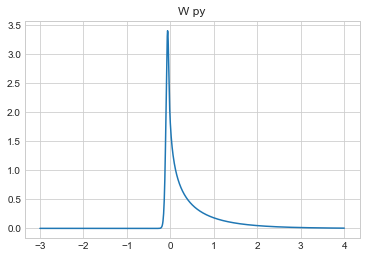

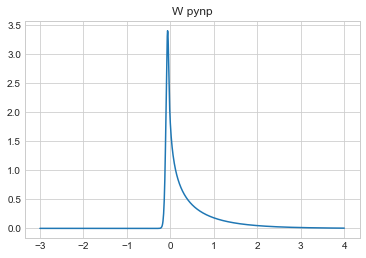

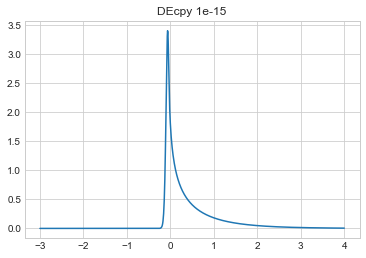

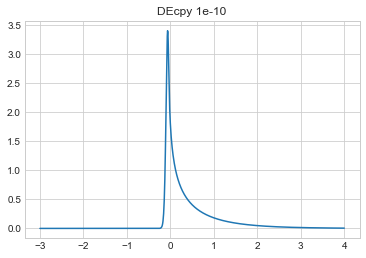

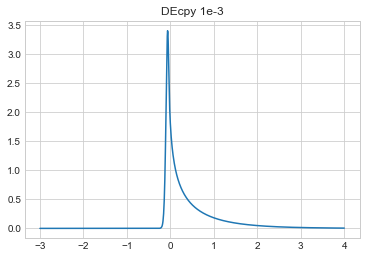

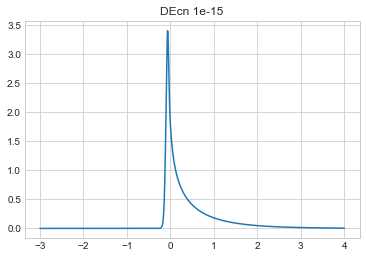

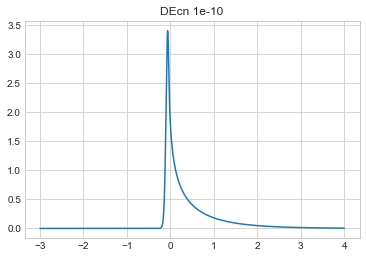

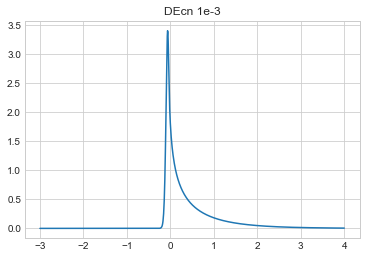

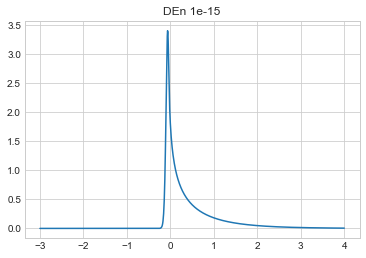

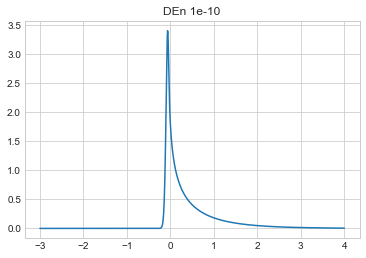

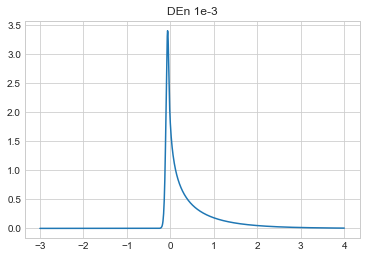

In [39]:
xh = dx['1000']
for method in pdf.keys():
    yh = [pdf[method](x) for x in xh]
    plt.plot(xh,yh)
    plt.title(method)
    plt.show();

***
<a id=references></a>
# <font color=brown> References </font>
This notebook belongs to supplementary materials of the paper submitted to Journal of Statistical Computation and
Simulation and available at  <https://arxiv.org/abs/2105.04427>.
* Hančová, M., Gajdoš, A., Hanč, J. (2021). A practical, effective calculation of gamma difference distributions with open data science tools. arXiv:2105.04427 [cs, math, stat], https://arxiv.org/abs/2105.04427

### Abstract of the paper

At present, there is still no officially accepted and extensively verified implementation of computing the gamma difference distribution allowing unequal shape parameters. We explore four computational ways of the gamma difference distribution with the different shape parameters resulting from time series kriging, a forecasting approach based on the best linear unbiased prediction, and linear mixed models. The results of our numerical study, with emphasis on using open data science tools, demonstrate that our open tool implemented in high-performance Python(with Numba) is exponentially fast, highly accurate, and very reliable. It combines numerical inversion of the characteristic function and the trapezoidal rule with the double exponential oscillatory transformation (DE quadrature). At the double 53-bit precision, our tool outperformed the speed of the analytical computation based on Tricomi's $U(a, b, z)$ function in CAS software (commercial Mathematica, open SageMath) by 1.5-2 orders. At the precision of scientific numerical computational tools, it exceeded open SciPy, NumPy, and commercial MATLAB 5-10 times. The potential future application of our tool for a mixture of characteristic functions could open new possibilities for fast data analysis based on exact probability distributions in areas like multidimensional statistics, measurement uncertainty analysis in metrology as well as in financial mathematics and risk analysis. 